## Chapter 2. End-to-End Machine Learning Project

Notes taken from [here](https://www.safaribooksonline.com/library/view/hands-on-machine-learning/9781491962282/ch02.html).

Original notebook available [here](https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb).

---

### Look at the Big Picture

- Will build a model of housing prices in California using census data.
- Data contains features such as 'median income', 'population' for block groups.
- Block groups are the smallest area for which the US Census Bureau publishes stats.

The model we build should be able to predict housing prices given the other metrics.

#### Frame the Problem

Building a model isn't the goal. What is the business purpose?
In this example, our output (price) will be fed to another system, along with other signals, to determine how investments should be made.

Another question is what is currently available?
Apparently they have a slow manual process with a 15% error rate.

#### Select a Performance Measure

RMSE (root mean squared error) is very common. It measures standard deviation of the errors the system makes during predictions.

Sometimes other methods may be preferred such as MAE (Mean Absolute Error or Average Absolute Deviation). 

RMSE gives exponentially more weight to larger errors. 

If being off by 2 is twice as bad as off by 1, MAE is more appropriate.
If being off by 2 is more than twice as bad as off by 1, RMSE is more appropriate.

Generally, RMSE gives better results.

#### Check the Assumptions.

We're sure we need to predict prices based on all other attributes. Perhaps we could have just classified as 'high', 'medium', 'low', and used classification instead of regression, but it sounds like we need regression here.

---

### Get the Data

#### Download the Data

We'll use a function that only downloads the file if it doesn't already exist.

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing/"
REMOTE_FILE_NAME = 'housing.tgz'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + REMOTE_FILE_NAME
LOCAL_DATA_DIR = './tmp/'
DOWNLOAD_PATH = LOCAL_DATA_DIR + REMOTE_FILE_NAME

def fetch_housing_data():
    if not (os.path.exists(DOWNLOAD_PATH)):
        os.makedirs(LOCAL_DATA_DIR, exist_ok=True)
        tgz_path = os.path.join(LOCAL_DATA_DIR, REMOTE_FILE_NAME)
        urllib.request.urlretrieve(HOUSING_URL, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=LOCAL_DATA_DIR)
        housing_tgz.close()
        

fetch_housing_data()

Load the downloaded CSV into a Pandas Dataframe..

In [2]:
import pandas as pd

def load_housing_data():
    csv_path = os.path.join(LOCAL_DATA_DIR, "housing.csv")
    return pd.read_csv(csv_path)

#### Take a Quick Look at the Data Structure

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


- each row represents one district
- there are 10 attributes

'info' method can be useful for summarizing a dataframe:

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


'ocean_proximity' column repeates, it's probably cateogorical. Let's check the counts.

In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

'describe' method can be useful for summarizing numerical features:

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


we can plot a histogram of all the numerical attributes at once:

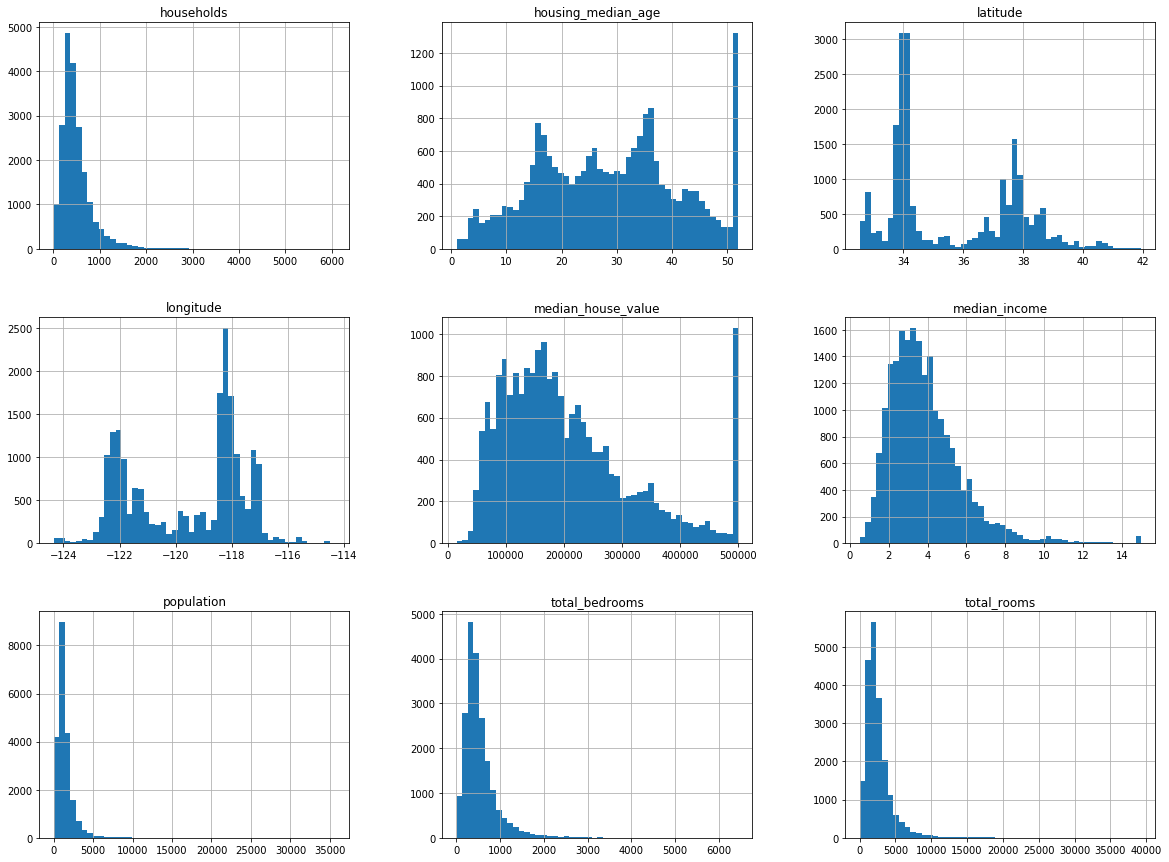

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

a few observations:

- median income isn't in USD. instead, it's been scaled to be between 0.5 and 15
- median age and median house values have been capped

#### Create a Test Set

We can create a test set by just randomly selecting some % (say 20%) of the data and the other 80% as training data.

In [8]:
import numpy as np

def split_train_test(data, test_ratio):

    # creates a list of unique, random numbers with the same length as the dataset
    shuffled_indices = np.random.permutation(len(data))
    
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

we can then split the data as follows:

In [9]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


this works, but will produce different results every time it is run as it is random. You could seed the RNG, but it would break if the dataset were to be updated.

One common solution is to create a hash of each row's ID and use the last byte to decide which set to put it into. 
IE, if the last byte is < 51 it's test set as 51/256 ~= 20%. It could be implemented as follows if we use the lat/lon as a unique ID for the data.

In [10]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()   # adds an `index` column

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

sci-kit learn also includes methods for creating train/test splits, such as this which does the same as our split_train_set method from above:

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

stratefied splitting is a thing when you want to maintain a certain distribution of an attribute in your training data

In [12]:
#stratefied splitting..
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)

# dataframe.where:
# Return an object of same shape as self and whose corresponding entries are from self where cond is True
# and otherwise are from other.
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

housing["income_cat"].value_counts() / len(housing)
# here we can see the distribution of 'income_cat' across the whole dataset

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    # we're iterating over all splits, but because n_splits=1 we only have 1 really
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [14]:
# using stratified split, we maintain that distribution in our training and test data
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [15]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [16]:
# and with a random split, the distributution is slightly off
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set["income_cat"].value_counts() / len(test_set)

3.0    0.358527
2.0    0.324370
4.0    0.167393
5.0    0.109496
1.0    0.040213
Name: income_cat, dtype: float64

In [17]:
# restore the strat sets to their original state
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

### Discover and Visualize the Data to Gain Insights

The dataset isn't too large, so we can explore it directly. If it were larger we might want to create an 'exploration' subset. 

Let's make a copy of the training set to play around with:

In [18]:
housing = strat_train_set.copy()

#### Visualizing Geographical Data

Since we have lat/lon data, it makes sense to plot those against each other:

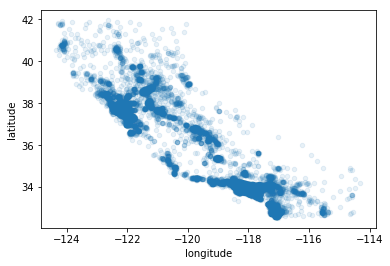

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

We can add housing prices as color and population as size of point.

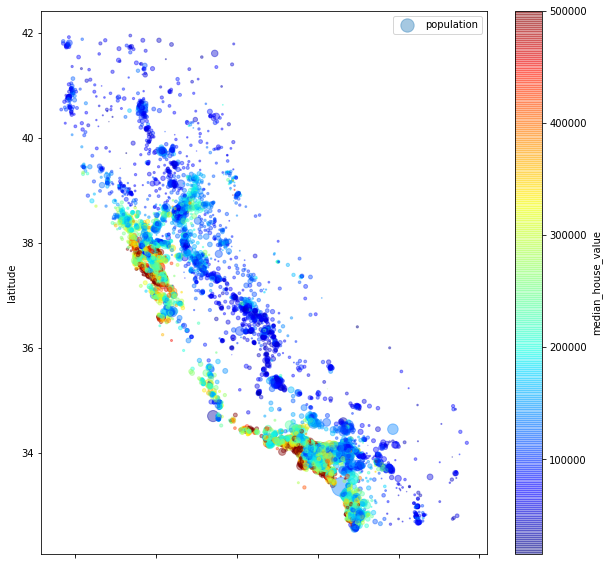

In [20]:
# s = size of each point
# c = color of each point
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             figsize=(10,10)
)


It seems clear from this that housing prices are high in densely populated areas, close to the coast.

#### Looking for Correlations

We can calculate the correlation between every pair of variables (aka Pearson's r).

In [21]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [22]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlations range between -1 and 1. 1 means high positive correlation, -1 high negative correlation.

It only shows linear correlations.

We can also view the correlations graphically using a scatter matrix:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4968fe710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe4bcca34a8>]], dtype=object)

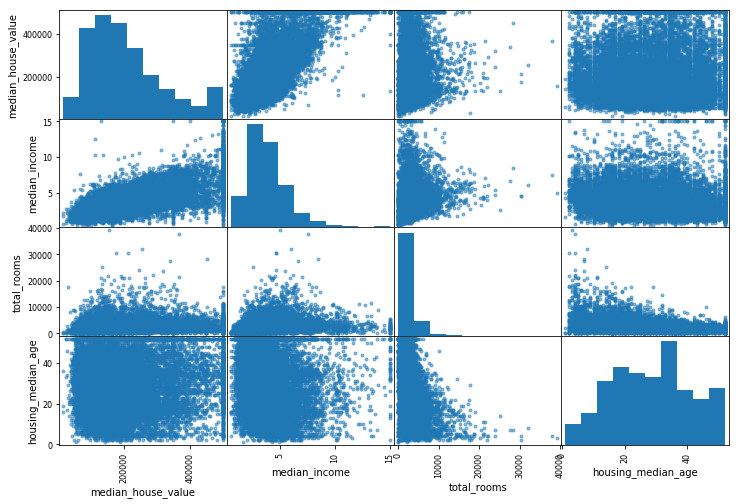

In [23]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

It looks like there's a high correlation with median income, so let's zoom in:

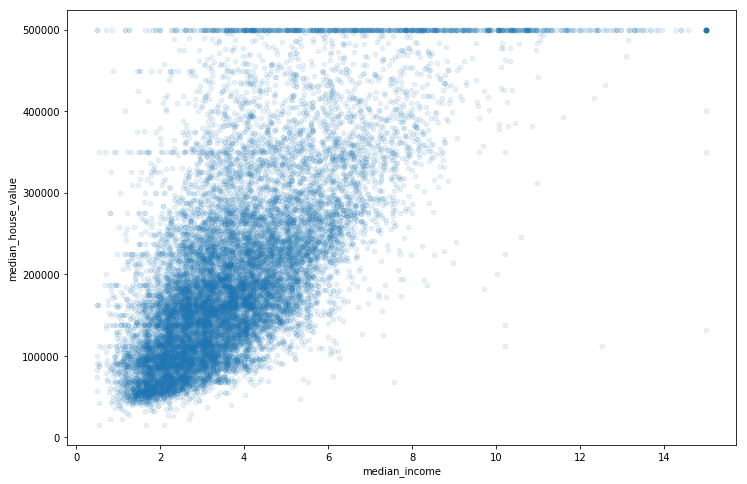

In [24]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, figsize=(12, 8))

The correlation definitely looks strong. The cap at 500k is obvious, and there are a few other strange horizontal lines that probably aren't accurate. Let's check the value counts.

In [25]:
print(housing.shape)
housing['median_house_value'].value_counts().head(10)

(16512, 10)


500001.0    786
137500.0    102
162500.0     91
112500.0     80
187500.0     76
225000.0     70
350000.0     65
87500.0      59
150000.0     58
175000.0     52
Name: median_house_value, dtype: int64

#### Experimenting with Attribute Combinations

Sometimes combining attributes can be useful. 
For instance:
- rooms per household instead of total rooms
- bedrooms per room
- population per household 

let's try these and see how they're correlated with the median price:

In [26]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

all 3 of these 'combined attributes' correlate well with the median price. excellent!

### Prepare the Data for Machine Learning Algorithms

some reasons for automating the preperation of data for ML:
- allows transforms to be easily reproduced on new/updated data
- you can build a library of useful techniques
- you can use these transforms in the live system on incoming data
- can experiment more easily

let's revert to clean data and separate labels from predictors

In [27]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Data Cleaning

Most ML algorithms can't deal with missing features. Generally there are 3 options:
- get rid of the offending records that have missing data
- get rid of the attribute from all records
- set the attribute to zero, the median, or some other calculated value.

We'll try option 3. Sci-kit learn provides an Imputer object that will handle filling in missing data with medians etc.

In [28]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
# we need a DF with only numeric values for the imputer to work
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

X = imputer.transform({housing_num})
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


#### SCIKIT-LEARN DESIGN

Main principals are:

- **Consistency**: interfaces simple and consistent.
    - *Estimators*: able to estimate parameters based on a dataset, like the 'Imputer'. Estimation performed by 'fit' method.
    - *Transformers*: Some estimators can transform a dataset via the 'transform' method, such as 'Imputer'. They also have 'fit_transform' method which combines 'fit' and 'transform' but are sometimes optimized to be faster than doing the two separately.
    - *Predictors* 
- **Inspection**: The estimator's hyperparameters are available via instance methods, and learned parameters are also available via an underscore suffix.
- **Nonproliferation of Classes**: Datasets are just numpy arrays or scipy sparse matrices, and hyperparams are just strings/numbers.
- **Composition**: Basic building blocks are reused as much as possible.
- ** Sensible Defaults**: Can create a basic system without much tweaking.


#### Handling Text and Categorical Data

Most ML algorithms work only with numbers and not categorical data. We can use the 'LabelEncoder' to transform from categorical to numerical:

In [29]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)
print(encoder.classes_)
print(housing_cat.head(3))

[0 0 4 ..., 1 0 3]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
Name: ocean_proximity, dtype: object


a problem here is that ML algorithms will assume 1,2 closer than 1.6, etc., but really there's no correlation. Instead of a range of numbers for categorical, we can create a boolean column per value, aka 'one-hot-encoding'.  ScikitLearn provides a 'OneHotEncoder'

note: fit_transform() expects a 2d array, but housing_cat_encoded is a 1d array so we need to reshape it:

In [30]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

the result is a 'sparse matrix'. this is because for a column with many cateogories, you would end up with many mostly empty columns (0's). Sparse matrix represents this in an efficient manor. Using 'to_array' we can get a regular array, and compare to the original 'housing_cat' above you can see the values line up.

In [31]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

we can combine LabelEncoder and OneHotEncoder in one call to 'LabelBinarizer'. It returns a dense numpy array by default:

In [32]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [33]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], 
      dtype='<U10')

#### Custom Transformers

wrapping custom data prep as a transformers will allow it to be used more easily within scikit learn 'pipelines'. Here is an example that does the feature combination from before:

In [34]:

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None, **fit_params):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs[0]

array([-121.89, 37.29, 38.0, 1568.0, 351.0, 710.0, 339.0, 2.7042,
       '<1H OCEAN', 4.625368731563422, 2.094395280235988], dtype=object)

we added one hyperparameter, 'add_bedrooms_per_room'. The more of these we add the more easily we can try different configurations when testing algorithms.

#### Feature Scaling

many ML algorithms don't perform well when data has very different scales. Our data here for instance has room ranged from 6 to 39,320.. too much range!! Two common techniques to account for this are 'normalization' and 'standardization'.

*normalization*: shift and scale values to be between 0 and 1. Scikit has MinMaxScalar for this.

*standardization*: subtracts the mean and divies by the variance. resulting distribution has mean of 0 and std. deviation of 1. This is much less affected by outliers. Scikit has 'StandardScalar' for this.

#### Transformation Pipeline

Scikit provides 'Pipeline' class to organize a sequence of transformations. Here's an example:

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
pd.DataFrame(housing_num_tr).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928


The pipeilne constructor takes a list of estimators (labels are arbitrary).

- calling 'fit' on pipeline calls 'fit_transform' on each trasnformer, until the last one which it just calls 'fit' on.
- the final estimator's methods are exposed. in this case, 'standardscaler' methods 

We have a pipeline for the numerical attributes, but we want one for the categorical attributes too. We can use Scikit's 'FeatureUnion' to have them generate in parallel and then concatenate them. 

Since Scikit learn doesn't natively support pandas dataframes we need to create an Estimator that transforms a dataframe into a numpy 2D array:

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None,**fit_params):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

we can then use this selector as the first stage in our 2 pipelines:

In [37]:
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

In [38]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizerPipelineFriendly()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [39]:
# huzzah, a fully transformed, standardized, labelized dataset:
housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared.shape)
pd.DataFrame(housing_prepared).head()

(16512, 16)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0


### Select and Train a Model

We:
- framed the problem
- explored the data
- sampled a training and test set
- wrote a transform pipeline

we can now train a ML model.

Let's start with a linear regression:

In [40]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

that's it, and we have a working model. Let's try it out:

In [41]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


it's working, but not great.. Let's measure the error:

In [42]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

not great, let's try a decision tree. it can detect non-linear relationships:

In [43]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [44]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

It's overfitting the data pretty badly. Since we're generating predictions on the training data the model doesn't have to deal with anything it hasn't seen before.

#### Better Evaluation Using Cross-Validation

We can use cross validation to better estimate the models error. Here we will run validation 10 times on different splits:

In [45]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 69127.80056135  65929.16029285  70266.89666699  69578.99788018
  71517.09036798  74547.62218306  71242.31603297  71219.55936922
  76734.71987678  69979.0728053 ]
Mean: 71014.3236037
Standard deviation: 2804.68207324


Let's measure the linear regression:

In [46]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
    scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


Let's do some ensemble learning with 'RandomForest' model for fun:

In [47]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
r_tree_mse = mean_squared_error(housing_labels, housing_predictions)
r_tree_rmse = np.sqrt(r_tree_mse)
print(r_tree_rmse)

r_forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
    scoring="neg_mean_squared_error", cv=10)
r_forest_rmse_scores = np.sqrt(-r_forest_scores)
display_scores(r_forest_rmse_scores)

22484.6223221
Scores: [ 52574.89840809  49372.19759906  52380.54352295  55502.65865621
  52636.99853638  56099.16506345  51693.40550744  50425.7774816
  55889.75064866  53661.34848848]
Mean: 53023.6743912
Standard deviation: 2164.29039323


This is working well, but it looks like it is still overfitting since the x-validation performs worse than the model trained with the whole training set predicting itself. Before tuning this model too much we should try other approaches (SVM, Neural Net etc.).

### Fine-Tune Your Model

#### Grid Search

Scikit's GridSearchCV will try all hyperparameters you tell it to using x-validation.

Here we'll train all 3x4 combos fo the first hash, then all 1x2x3 combos of the 2nd, so 12+6 = 18 trainings each.

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=6)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=6,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [49]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

looks like it chose the highest n_estimators, so let's try some higher values:

In [50]:
param_grid = [
    {'n_estimators': [30, 50, 100], 'max_features': [4, 6, 8]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=6)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=6,
       param_grid=[{'n_estimators': [30, 50, 100], 'max_features': [4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [51]:
print(grid_search.best_params_)

{'max_features': 8, 'n_estimators': 100}


In [52]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50587.631931 {'max_features': 4, 'n_estimators': 30}
50086.5578805 {'max_features': 4, 'n_estimators': 50}
49631.0560829 {'max_features': 4, 'n_estimators': 100}
50094.8560133 {'max_features': 6, 'n_estimators': 30}
49547.9200297 {'max_features': 6, 'n_estimators': 50}
49300.3637617 {'max_features': 6, 'n_estimators': 100}
50226.0067101 {'max_features': 8, 'n_estimators': 30}
49428.0222156 {'max_features': 8, 'n_estimators': 50}
49261.6907009 {'max_features': 8, 'n_estimators': 100}


we could probably keep tuning with higher n_estimators but this is good enough for now. ~49000 RMSE is better than the old ~52800 without tuning the algorithm.

#### Randomized Search

Grid search is good when there are a few combinations but when you want to explore a large space there is RandomizedSearchCV. You can tell it how many iterations to run and it'll just go as long as you tell it to.

#### Ensemble Methods

Combining multiple models that work well will help to account for the different types of errors that arise. This is discussed in a later chapter.

#### Analyze the Best Models and Their Errors

The models can tell you which features were most important to them, ie:

In [53]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.37287925346426115, 'median_income'),
 (0.1495428401232112, 'INLAND'),
 (0.11167659935430746, 'pop_per_hhold'),
 (0.0712156645724909, 'longitude'),
 (0.065028922052665056, 'latitude'),
 (0.059729871050295869, 'bedrooms_per_room'),
 (0.05224180798648171, 'rooms_per_hhold'),
 (0.042181584222750076, 'housing_median_age'),
 (0.015831025416256295, 'total_rooms'),
 (0.01536196708756493, 'population'),
 (0.014755053294228083, 'total_bedrooms'),
 (0.014430154440500585, 'households'),
 (0.0083090535106673975, '<1H OCEAN'),
 (0.0041754244630378126, 'NEAR OCEAN'),
 (0.0025376356141237821, 'NEAR BAY'),
 (0.00010314334715778589, 'ISLAND')]

#### Evaluate Your System on the Test Set

We can now test our finely tuned model against the original holdout set:

In [54]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47178.003992948856

performance here will often be worse than during training. If that happens, don't tune to fit the holdout set as that will probably not generalize to more data.

### Exercises

**Q1**: Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

**A1**:

In [55]:
# commenting out as it's slow

# from sklearn.svm import SVR 

# param_grid = [
#     {'kernel': ['linear'], 'C': [1, 10]},
#     {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [1, 10]}
#   ]

# svr = SVR()

# svr_grid_search = GridSearchCV(svr, param_grid, cv=5,
#                            scoring='neg_mean_squared_error', n_jobs=6)

# svr_grid_search.fit(housing_prepared, housing_labels)

In [56]:
# cvres = svr_grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

The best is a linear Kernel with C value of 10, but still has an RMSE of ~84,000. This is not good!

**Q1**: Try replacing GridSearchCV with RandomizedSearchCV.

**A1**:

In [57]:
# commenting out as it's slow

# from scipy.stats import randint as sp_randint
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {"n_estimators": sp_randint(1, 1000),
#               "max_features": sp_randint(1, housing_prepared.shape[1] - 1)
#              }


# forest_reg = RandomForestRegressor()

# random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist,
#                                    n_iter=20, verbose=True, n_jobs=6)

# random_search.fit(housing_prepared, housing_labels)

In [58]:
# let's try the best one:
# X_test = strat_test_set.drop("median_house_value", axis=1)
# y_test = strat_test_set["median_house_value"].copy()

# X_test_prepared = full_pipeline.transform(X_test)

# final_predictions = random_search.best_estimator_.predict(X_test_prepared)

# final_mse = mean_squared_error(y_test, final_predictions)
# final_rmse = np.sqrt(final_mse)
# final_rmse

That's slightly better than we had with gridsearch!

**Q3**: Try adding a transformer in the preparation pipeline to select only the most important attributes.

**A3**:

In [59]:
# we already have feature importances from earlier
feature_importances

array([  7.12156646e-02,   6.50289221e-02,   4.21815842e-02,
         1.58310254e-02,   1.47550533e-02,   1.53619671e-02,
         1.44301544e-02,   3.72879253e-01,   5.22418080e-02,
         1.11676599e-01,   5.97298711e-02,   8.30905351e-03,
         1.49542840e-01,   1.03143347e-04,   2.53763561e-03,
         4.17542446e-03])

In [60]:
from sklearn.base import BaseEstimator, TransformerMixin

# we'll select 5 features to test
k_features = 5

def indices_of_top_k(arr, k):
    # agrpartition will sort by index , ensuring the element at k is in the correct position when the array is sorted.
    # therefore, the largest elements will all be at -k..end_of array ([-k:])
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        # assume we already have the feature_importances array         
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None, **fit_params):
        # configure the transformers by calculating the indices of the best features
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [61]:
feature_pipeline = Pipeline([
        ('full', full_pipeline),
        ('feature', TopFeatureSelector(feature_importances, k_features)),
    ])

# feature_prepared = feature_pipeline.fit(housing) ## same as below
feature_prepared = feature_pipeline.fit(housing).transform(housing)

In [62]:
top_k_feature_indices = indices_of_top_k(feature_importances, k_features)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [63]:
pd.DataFrame(feature_prepared).head(2)

,0,1,2,3,4
0,-1.156043,0.771950,-0.614937,-0.086499,0.0
1,-1.176025,0.659695,1.336459,-0.033534,0.0


In [64]:
pd.DataFrame(housing_prepared).iloc[:, top_k_feature_indices].head(2)

,0,1,7,9,12
0,-1.156043,0.771950,-0.614937,-0.086499,0.0
1,-1.176025,0.659695,1.336459,-0.033534,0.0


looks like it's selecting the right columns!

**Q4**: Try creating a single pipeline that does the full data preparation plus the final prediction.

**A4**:

In [65]:
prepare_select_and_predict_pipeline = Pipeline([
    ('feature_pipeline', feature_pipeline),
    ('svm_reg', RandomForestRegressor())
])

In [66]:
prepare_select_and_predict_pipeline.fit(X=housing, y=housing_labels)

Pipeline(steps=[('feature_pipeline', Pipeline(steps=[('full', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_in...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [67]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 254020.  344200.  211270.   45070.]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


**Q5**: Automatically explore some preparation options using GridSearchCV.

In [68]:
prepare_select_and_predict_pipeline.get_params()

{'feature_pipeline': Pipeline(steps=[('full', FeatureUnion(n_jobs=1,
        transformer_list=[('num_pipeline', Pipeline(steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('imputer', Imputer(axis=0,...  8.30905e-03,
          1.49543e-01,   1.03143e-04,   2.53764e-03,   4.17542e-03]),
           k=5))]),
 'feature_pipeline__feature': TopFeatureSelector(feature_importances=array([  7.12157e-02,   6.50289e-02,   4.21816e-02,   1.58310e-02,
          1.47551e-02,   1.53620e-02,   1.44302e-02,   3.72879e-01,
          5.22418e-02,   1.11677e-01,   5.97299e-02,   8.30905e-03,
          1.49543e-01,   1.03143e-04,   2.53764e-03,   4.17542e-03]),
           k=5),
 'feature_pipeline__feature__feature_importances': array([  7.12156646e-02,   6.50289221e-02,   4.21815842e-02,
          1.58310254e-02,   1.47550533e-02,   1.53619671e-02,
          1.44301544e-02,   

In [69]:
param_grid = [
        {'feature_pipeline__full__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
        'feature_pipeline__feature__k': [3, 4, 5, 6, 7]}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] feature_pipeline__feature__k=3, feature_pipeline__full__num_pipeline__imputer__strategy=mean 
[CV] feature_pipeline__feature__k=3, feature_pipeline__full__num_pipeline__imputer__strategy=mean 
[CV] feature_pipeline__feature__k=3, feature_pipeline__full__num_pipeline__imputer__strategy=mean 
[CV] feature_pipeline__feature__k=3, feature_pipeline__full__num_pipeline__imputer__strategy=mean 
[CV]  feature_pipeline__feature__k=3, feature_pipeline__full__num_pipeline__imputer__strategy=mean, total=   0.8s
[CV] feature_pipeline__feature__k=3, feature_pipeline__full__num_pipeline__imputer__strategy=mean 
[CV]  feature_pipeline__feature__k=3, feature_pipeline__full__num_pipeline__imputer__strategy=mean, total=   0.8s
[CV] feature_pipeline__feature__k=3, feature_pipeline__full__num_pipeline__imputer__strategy=median 
[CV]  feature_pipeline__feature__k=3, feature_pipeline__full__num_pipeline__imputer__strategy=mean, total=   0.8s
[

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.4s


[CV] feature_pipeline__feature__k=5, feature_pipeline__full__num_pipeline__imputer__strategy=median 
[CV]  feature_pipeline__feature__k=5, feature_pipeline__full__num_pipeline__imputer__strategy=mean, total=   0.9s
[CV] feature_pipeline__feature__k=5, feature_pipeline__full__num_pipeline__imputer__strategy=median 
[CV]  feature_pipeline__feature__k=5, feature_pipeline__full__num_pipeline__imputer__strategy=median, total=   0.9s
[CV] feature_pipeline__feature__k=5, feature_pipeline__full__num_pipeline__imputer__strategy=median 
[CV]  feature_pipeline__feature__k=5, feature_pipeline__full__num_pipeline__imputer__strategy=median, total=   0.7s
[CV] feature_pipeline__feature__k=5, feature_pipeline__full__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_pipeline__feature__k=5, feature_pipeline__full__num_pipeline__imputer__strategy=median, total=   0.7s
[CV] feature_pipeline__feature__k=5, feature_pipeline__full__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_pipel

[CV]  feature_pipeline__feature__k=7, feature_pipeline__full__num_pipeline__imputer__strategy=most_frequent, total=   1.7s
[CV]  feature_pipeline__feature__k=7, feature_pipeline__full__num_pipeline__imputer__strategy=most_frequent, total=   1.7s
[CV]  feature_pipeline__feature__k=7, feature_pipeline__full__num_pipeline__imputer__strategy=most_frequent, total=   1.8s
[CV]  feature_pipeline__feature__k=7, feature_pipeline__full__num_pipeline__imputer__strategy=most_frequent, total=   1.7s


[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:   22.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('feature_pipeline', Pipeline(steps=[('full', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_in...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{'feature_pipeline__full__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_pipeline__feature__k': [3, 4, 5, 6, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

In [70]:
grid_search_prep.best_params_

{'feature_pipeline__feature__k': 7,
 'feature_pipeline__full__num_pipeline__imputer__strategy': 'most_frequent'}

Looks like the best is to use 7 features and the median imputer.